<a href="https://colab.research.google.com/github/dhruv21csu155/aaies/blob/main/Assignment13_SVM_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python program to implement Credit Card Fraud detection using Support Vector Machine classification.

Link for the Dataset:

https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud

## The Code

### Imports

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from time import time
import joblib

from warnings import filterwarnings
filterwarnings('ignore')

### Load the dataset into a DataFrame

In [21]:
# Download the csv from the kaggle website and Load the dataset into a DataFrame
def load_dataset():
    # TODO: Load the dataset
    # Define the dataset as a Pandas DataFrame
    # fetch dataset
    df = pd.read_csv('card_transdata.csv')

    # data (as pandas dataframes)
    return df

### Function for applying DQM Checks

In [22]:
def data_quality_checks(df):
    # Handling missing values
    print(f"\nAmount of missing data: {df.isnull().sum().sum()}")
    df.dropna(inplace=True)

    # Check for duplicates
    print(f"\nAmount of duplicate data: {df.duplicated().sum()}\n")
    df.drop_duplicates(inplace=True)

    # Check for unique values in categorical columns
    for col in df.columns:
        print(f"Unique values in {col} : {df[col].nunique()}")

    # Check for outliers using z-score
    numerical_columns = df.select_dtypes(exclude=["object"]).columns
    z_scores = np.abs((df[numerical_columns] - df[numerical_columns].mean()) / df[numerical_columns].std())
    outliers = (z_scores > 3).any(axis=1)
    print(f"\nOutliers Detected by Z-Score: {df[outliers].shape[0]}\n")

### Applying profiling and visualization

In [23]:
def profiling_visualization(df):
    # Display basic information about the dataset
    df.info()
    print()

    # Descriptive statistics
    display(df.describe())

    # Categorical feature profiling
    print("\nCategorical Feature Profiling:")
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        # take top 16 values only and plot them in a bar chart
        plt.title(f"{col} Distribution", fontdict={'fontsize': 20})
        df[col].value_counts().sort_values(ascending=False).head(20).plot(kind='bar')
        plt.xticks(rotation=90)
        plt.show()
    print("-"*50)

    # Numerical feature profiling
    print("\nNumerical Feature Profiling:")
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_columns:
        fig , ax = plt.subplots(1,2, figsize=(13,5))
        plt.suptitle(f"{col} Distribution", fontsize= 20)
        data = df[col].sample(200, random_state=42)
        ax[0].set_title(f"{col} Histogram", fontdict={'fontsize': 10})
        sns.histplot(data, ax=ax[0])
        ax[1].set_title(f"{col} Boxplot", fontdict={'fontsize': 10})
        sns.boxplot(data, ax=ax[1], orient='h')
        plt.show()
    print("-"*50)

### Function for Feature engineering

In [24]:
def feature_engineering(df):
    # Normalize the Numerical values
    stdscaler = StandardScaler()
    df.iloc[:,:3] = stdscaler.fit_transform(df.iloc[:,:3])

    # Remove class imbalance from the target variable present in the dataset
    from imblearn.over_sampling import SMOTE
    smte = SMOTE()

    # Assuming you have a DataFrame 'df' with features and labels
    X = df.drop('fraud', axis=1)  # Features
    y = df['fraud']  # Labels

    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Display the class distribution before and after SMOTE
    print("Class distribution before SMOTE:\n", y.value_counts())
    print("\nClass distribution after SMOTE:\n", y_resampled.value_counts())

    # If you want to create a new DataFrame with the resampled data
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='fraud')], axis=1)

    df_resampled.iloc[:,3:] = df_resampled.iloc[:,3:].astype("int64")

    return df_resampled

### Train test split

In [25]:
def split_data(df):
    # Split the data into train test ratio for further processing using sklearn

    sample_df = df.groupby('fraud', group_keys=False).apply(lambda x: x.sample(min(len(x), 50000), random_state=42))

    X = sample_df.drop("fraud", axis=1)
    y = sample_df["fraud"]

    X_train, X_test, y_train, t_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, t_test

### Prediction using SVM

In [26]:
def make_SVM_predict(X_train, X_test,y_train):
    # Code to instantiate the SVM model with proper hyperparameters
    from sklearn.ensemble import VotingClassifier

    # Define individual SVM models
    svm_model1 = SVC(kernel='linear', C=5, probability=True)
    svm_model2 = SVC(kernel='rbf', C=5, probability=True)
    svm_model3 = SVC(kernel="poly",degree=3, C=5, probability=True)

    # Create an ensemble using a voting classifier
    ensemble_model = VotingClassifier(estimators=[('svm1', svm_model1),
                                                  ('svm2', svm_model2),
                                                  ('svm3', svm_model3)], voting='soft', n_jobs=-1)

    # Train the ensemble model
    start = time()
    ensemble_model.fit(X_train, y_train)
    print(f"Training time: {time() - start} seconds")
    joblib.dump(ensemble_model, 'ensemble_model_three')


    # Make predictions
    start = time()
    y_pred = ensemble_model.predict(X_test)
    print(f"Prediction time: {time() - start} seconds")

    return y_pred

### Evaluate

In [27]:
def evaluate(y_pred, y_test):
    # Use different metrics to find the score of predicted result
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}\n')

    print(classification_report(y_test, y_pred))

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.show()

### Main function to call the functions and to predict and evaluate the predictions

In [28]:
df = load_dataset()
display(df.head())

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0



Amount of missing data: 7

Amount of duplicate data: 0

Unique values in distance_from_home : 13746
Unique values in distance_from_last_transaction : 13746
Unique values in ratio_to_median_purchase_price : 13746
Unique values in repeat_retailer : 2
Unique values in used_chip : 2
Unique values in used_pin_number : 2
Unique values in online_order : 2
Unique values in fraud : 2

Outliers Detected by Z-Score: 1443

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13746 entries, 0 to 13745
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              13746 non-null  float64
 1   distance_from_last_transaction  13746 non-null  float64
 2   ratio_to_median_purchase_price  13746 non-null  float64
 3   repeat_retailer                 13746 non-null  float64
 4   used_chip                       13746 non-null  float64
 5   used_pin_number                 13746 non-nu

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000,13746.000000
mean,26.986967,4.911782,1.811992,0.880183,0.354139,0.102866,0.644406,0.084825
std,64.918476,20.968387,2.715292,0.324759,0.478269,0.303795,0.478710,0.278631
min,0.049270,0.000856,0.011373,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.816082,0.307066,0.482429,1.000000,0.000000,0.000000,0.000000,0.000000
50%,10.058839,1.014374,0.999819,1.000000,0.000000,0.000000,1.000000,0.000000
75%,26.060307,3.409086,2.064749,1.000000,1.000000,0.000000,1.000000,0.000000
max,2353.226927,990.070315,65.150879,1.000000,1.000000,1.000000,1.000000,1.000000



Categorical Feature Profiling:
--------------------------------------------------

Numerical Feature Profiling:


KeyError: ignored

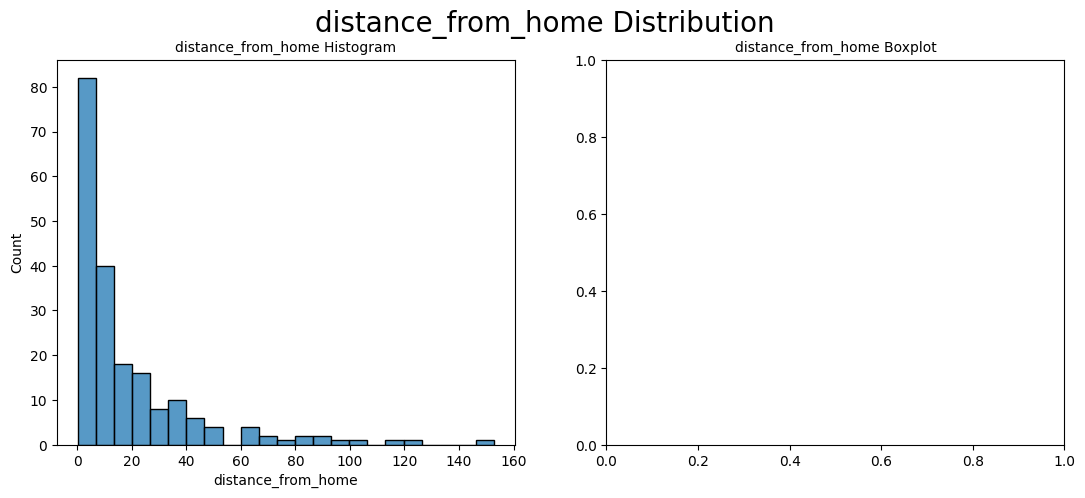

In [29]:
data_quality_checks(df)
profiling_visualization(df)

In [ ]:
df = feature_engineering(df)

In [ ]:
X_train, X_test ,y_train, y_test = split_data(df)
print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}, X_test: {X_test.shape}, y_test: {y_test.shape}")

In [ ]:
print("\nTraining the model...\n")
y_pred = make_SVM_predict(X_train, X_test, y_train)

In [ ]:
print("\nEvaluating the model...\n")
evaluate(y_pred, y_test)